In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Extract Tree Leaf Descriptions (Unsupervised)

We examine how the terminal nodes (leafs) of a decision tree can be extracted and described in scikit-learn

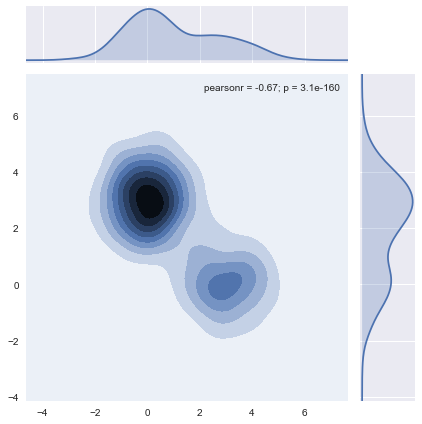

In [2]:
n_features = 2

n_class1 = 800
n_class2 = 400

loc1 = [0, 3]
loc2 = [3, 0]

class1 = np.random.normal(size=(n_class1, n_features)) + np.array(loc1)
class2 = np.random.normal(size=(n_class2, n_features)) + np.array(loc2)

X = np.vstack([class1, class2])

g = sns.jointplot(x=X[:, 0], y=X[:, 1], kind='kde')

## generate independent data distribution

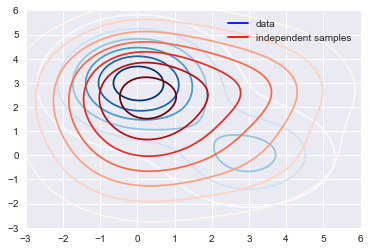

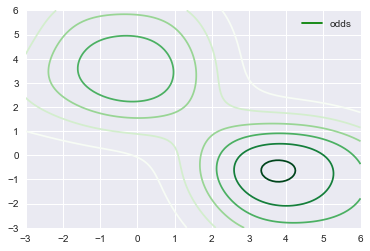

In [3]:
from sklearn.neighbors import KernelDensity

model = KernelDensity()

n_independent_samples = 2000
independent_samples = np.empty((n_independent_samples, n_features))
for i_feature in range(n_features):
    model.fit(X[:, i_feature][:, None])
    independent_samples[:, i_feature][:, None] = model.sample(n_samples=n_independent_samples)
    
n1d=100
x1d = y1d = np.linspace(-3, 6, n1d)
xgrid, ygrid = np.meshgrid(x1d, y1d, indexing='ij')
points = np.array([xgrid.flatten(), ygrid.flatten()]).T

model = KernelDensity()
model.fit(X)
density_X = np.exp(model.score_samples(points).reshape(n1d, n1d))

model.fit(independent_samples)
density_independent = np.exp(model.score_samples(points).reshape(n1d, n1d))

fig, ax = plt.subplots()
ax.plot(0, 0, color='blue', label='data')
ax.contour(xgrid, ygrid, density_X, cmap='Blues')
ax.plot(0, 0, color='red',label='independent samples')
ax.contour(xgrid, ygrid, density_independent, cmap='Reds')
ax.legend()

fig, ax = plt.subplots()
ax.plot(0, 0, color='green', label='odds')
ax.contour(xgrid, ygrid, density_X/density_independent, cmap='Greens')
ax.legend()

## generate decision tree that distinguishes between the independent and the dependent datasets

(3200, 2) (3200,)


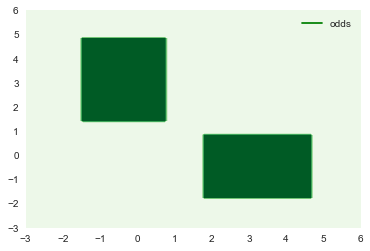

In [21]:
from sklearn.tree import DecisionTreeClassifier

X_full = np.concatenate([X, independent_samples], axis=0)
y = np.concatenate([np.ones(len(X)), np.zeros(len(independent_samples))], axis=0)
print(X_full.shape, y.shape)

model = DecisionTreeClassifier(max_leaf_nodes=10, max_depth=6)
model.fit(X_full, y)

density_tree = model.predict(points).reshape(n1d, n1d)

fig, ax = plt.subplots()
ax.plot(0, 0, color='green', label='odds')
ax.contourf(xgrid, ygrid, density_tree, cmap='Greens')
ax.legend()

In [138]:
from sklearn.tree import _tree
    
def recurse(model, node=None, rules=None, leaf_rules=None):
    if rules is None:
        rules = []
    if leaf_rules is None:
        leaf_rules = []
    if node is None:
        node = 0
    if model.tree_.feature[node] != _tree.TREE_UNDEFINED:
        name = model.tree_.feature[node]
        threshold = model.tree_.threshold[node]
        
        rules_left = rules + [[name, '<', threshold]]
        rules_right = rules + [[name, '>', threshold]]
        
        recurse(model, model.tree_.children_left[node], rules_left, leaf_rules)
        recurse(model, model.tree_.children_right[node], rules_right, leaf_rules)
    else:
        rules.append(model.tree_.value[node].flatten())
        leaf_rules.append(rules)
    return leaf_rules

rules = recurse(model)
values = np.array([rule[-1] for rule in rules])
print(np.sum(values, axis=0))
rules_true = [rule for irule, rule in enumerate(rules) if (values[:, 1] > values[:, 0])[irule]]
rules_true[0]

[ 2000.  1200.]


[[0, '>', -1.4599229097366333],
 [1, '<', 4.8902692794799805],
 [1, '>', -1.8106551170349121],
 [0, '<', 4.6914834976196289],
 [0, '<', 0.80671072006225586],
 [1, '>', 1.3781278133392334],
 array([ 448.,  567.])]

[ 1.20689655  1.125       1.10144928  2.265625    1.35227273  2.73170732
  1.34488735  1.59375     1.          1.21904762]


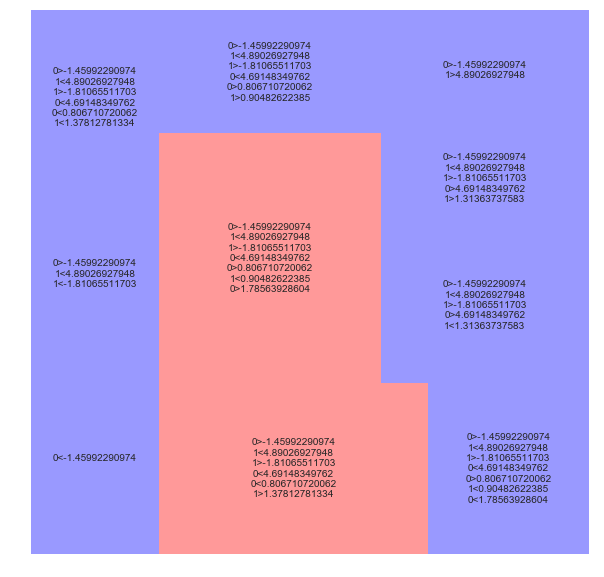

In [159]:
import squarify

colors = ['red' if rule[-1][1] > rule[-1][0] else 'blue' for rule in rules]
rule_labels = [[''.join([str(item) for item in subrule]) for subrule in rule[:-1]] for rule in rules]
labels = ['\n'.join(rule) for rule in rule_labels]

print(values[:, 1]/values[:, 0] + 1)

fig, ax = plt.subplots(figsize=(10, 10))
squarify.plot(sizes=values[:, 1] / values[:, 0] + 1, label=labels,
              color=colors, alpha=.4, ax=ax)
plt.axis('off')
plt.show()